In [1772]:
CLEAR_WORKSPACE = True
#%%
# Clear workspace variables
if CLEAR_WORKSPACE:
    from IPython import get_ipython
    get_ipython().magic('reset -sf')

In [2304]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from skimpy import skim
import pgeocode
import time

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter

from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.svm import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.preprocessing import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2173]:
# Call pathway
Desktop = os.path.join(os.path.expanduser("~"), "Desktop")
filepath_root = os.path.join(Desktop, "Interview")
os.path.exists(filepath_root)
train_data = 'Training_DataSet'
test_data = 'Test_Dataset'
# Read Data
car_train = pd.read_csv(filepath_root + '/' + train_data + '.csv')
car_test = pd.read_csv(filepath_root + '/' + test_data + '.csv')

## Data Cleaning

Remove columns that are unnecesary for model prediction
- ListingID: Listing ID shouldn't be a factor for consumers to decide the purchase
- VehBodystyle: only 1 unique value ('SUV')
- VehType: only 1 unique value ('Used')
- VehSellerNotes: Although some notes did contain some information about the vehicle features, vehicle feature column already exists

1. Number
- Remove the outlier rows for Dealer_Listing_Price
2. String
- Remove 
3. Bool

In [1776]:
# Removing Unnecessary Columns

# Save the deleting columns: ListingID, VehBodyStyle, VehType
train_ID,train_Vehbodystyle,train_Vehtype, train_VehSellerNotes = car_train['ListingID'], car_train['VehBodystyle'],car_train['VehType'],car_train['VehSellerNotes']
test_ID,test_Vehbodystyle,test_Vehtype,test_VehSellerNotes = car_test['ListingID'], car_test['VehBodystyle'],car_test['VehType'], car_test['VehSellerNotes']

# Now drop the columns since it's unnecessary for the prediction process.
car_train.drop(["ListingID","VehType","VehBodystyle","VehSellerNotes"], axis = 1, inplace = True)
car_test.drop(["ListingID","VehType","VehBodystyle","VehSellerNotes"], axis = 1, inplace = True)

# Check data size after dropping columns
print("\nTraining data after : {} ".format(car_train.shape)) 
print("Testing data: {} ".format(car_test.shape))


Training data after : (6298, 25) 
Testing data: (1000, 23) 


In [1777]:
skim(car_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 6298   │ │ string      │ 16    │                                                          │
│ │ Number of columns │ 25     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ │ bool        │ 2     │                                                          │
│                                │ int64       │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %    ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p75    ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ SellerRating             │   0 │       0 │     4.1 │    1.2 │      0 │      4 │    4.8 │       5 │ ▁  ▁▂█  │  │
│ │ SellerRevCnt             │   0 │       0 │     430 │   1300 │      0 │     28 │    400 │   15000 │    █    │  │
│ │ SellerZip                │   2 │   0.032 │   45000 │  20000 │   1100 │  29000 │  60000 │  100000 │ ▃▆█▇▂▁  │  │
│ │ VehListdays              │   2 │   0.032 │      56 │     68 │   0.29 │     13 │     74 │     820 │   █▁    │  │
│ │ VehMileage               │   2 │   0.032 │   26000 │  13000 │      0 │  17000 │  36000 │   83000 │  ▄█▇▃   │  │
│ │ VehYear                  │   0 │       0 │    2000 │    1.2 │   2000 │   2000 │   2000 │    2000 │ ▆▂ ██▁  │  │
│ │ Dealer_Listing_Price     │  52 │    0.83 │   32000 │   7500 │  18000 │  27000 │  36000 │   90000 │   ██▁   │  │
│ └──────────────────────────┴─────┴─────────┴─────────┴────────┴────────┴────────┴────────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                    ┃ NA      ┃ NA %        ┃ words per row             ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ SellerCity                     │       0 │           0 │                       1.3 │                  7900 │  │
│ │ SellerListSrc                  │       2 │       0.032 │                       1.3 │                  7900 │  │
│ │ SellerName                     │       0 │           0 │                       1.3 │                  7900 │  │
│ │ SellerState                    │       0 │           0 │                       1.3 │                  7900 │  │
│ │ VehColorExt                    │      73 │         1.2 │                       1.3 │                  7900 │  │
│ │ VehColorInt                    │     730 │          12 │                       1.3 │                  7900 │  │
│ │ VehDriveTrain                  │     400 │         6.4 │                       1.3 │                  7900 │  │
│ │ VehEngine                      │     360 │         5.7 │                       1.3 │                  7900 │  │
│ │ VehFeats                       │     280 │         4

In [1778]:
# Drop NA (can't drop NA for testing data because it requires all 1000 data points)
# Training data
car_train = car_train.dropna()
car_train = car_train[(car_train != "").all(axis=1)]

In [1779]:
car_train.nunique()

SellerCity              1139
SellerIsPriv               1
SellerListSrc              5
SellerName              1994
SellerRating              40
SellerRevCnt             756
SellerState               49
SellerZip               1549
VehCertified               2
VehColorExt              143
VehColorInt              100
VehDriveTrain             16
VehEngine                 84
VehFeats                 720
VehFuel                    4
VehHistory                32
VehListdays             4843
VehMake                    2
VehMileage              4308
VehModel                   2
VehPriceLabel              3
VehTransmission           27
VehYear                    5
Vehicle_Trim              26
Dealer_Listing_Price    2481
dtype: int64

In [1780]:
private_seller_counts = car_test['SellerIsPriv'].value_counts()
private_seller_counts

False    998
True       2
Name: SellerIsPriv, dtype: int64

After dropping all the NA rows, one noticable change is that SellerIsPriv column, which describes whether it was a private seller row is left with only 1 unique value. From the skim chart above, it was noticable that the true value was only a count of 14 having 0.0022 true rate, which is 0.2%.
In the testing data, it was shown that the data has only 2 True values.
Therefore, This column is going to be removed for convenience.

In [1781]:
'''
# Save and drop the column
train_private = car_train['SellerIsPriv']
test_private = car_test['SellerIsPriv']
car_train.drop(["SellerIsPriv"], axis = 1, inplace = True)
car_test.drop(["SellerIsPriv"], axis = 1, inplace = True)
'''

In [1782]:
skim(car_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5094   │ │ string      │ 16    │                                                          │
│ │ Number of columns │ 24     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                │ bool        │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p75    ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ SellerRating              │   0 │      0 │     4.2 │    1.1 │      0 │      4 │    4.8 │       5 │    ▁▂█  │  │
│ │ SellerRevCnt              │   0 │      0 │     460 │   1300 │      0 │     32 │    430 │   15000 │    █    │  │
│ │ SellerZip                 │   0 │      0 │   45000 │  20000 │   1700 │  30000 │  60000 │  100000 │ ▃▅█▇▂▁  │  │
│ │ VehListdays               │   0 │      0 │      57 │     68 │    1.7 │     15 │     75 │     820 │   █▁    │  │
│ │ VehMileage                │   0 │      0 │   27000 │  13000 │      5 │  17000 │  37000 │   83000 │  ▄█▇▃   │  │
│ │ VehYear                   │   0 │      0 │    2000 │    1.2 │   2000 │   2000 │   2000 │    2000 │ ▆▂ ██▁  │  │
│ │ Dealer_Listing_Price      │   0 │      0 │   32000 │   7600 │  18000 │  27000 │  36000 │   90000 │   ██▁   │  │
│ └───────────────────────────┴─────┴────────┴─────────┴────────┴────────┴────────┴────────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                     ┃ NA     ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ SellerCity                      │      0 │          0 │                        1.3 │                  6400 │  │
│ │ SellerListSrc                   │      0 │          0 │                        1.3 │                  6400 │  │
│ │ SellerName                      │      0 │          0 │                        1.3 │                  6400 │  │
│ │ SellerState                     │      0 │          0 │                        1.3 │                  6400 │  │
│ │ VehColorExt                     │      0 │          0 │                        1.3 │                  6400 │  │
│ │ VehColorInt                     │      0 │          0 │                        1.3 │                  6400 │  │
│ │ VehDriveTrain                   │      0 │          0 │                        1.3 │                  6400 │  │
│ │ VehEngine                       │      0 │          0 │                        1.3 │                  6400 │  │
│ │ VehFeats                        │      0 │          

In [1783]:
string_cols = car_train.select_dtypes(include=['object']).columns
string_cols
#num_cols = car_train.select_dtypes(include=['float64','int64']).columns
#num_cols

Index(['SellerCity', 'SellerListSrc', 'SellerName', 'SellerState',
       'VehColorExt', 'VehColorInt', 'VehDriveTrain', 'VehEngine', 'VehFeats',
       'VehFuel', 'VehHistory', 'VehMake', 'VehModel', 'VehPriceLabel',
       'VehTransmission', 'Vehicle_Trim'],
      dtype='object')

Thinking that SellerCity, SellerState, SellerZip, SellerName could be treated as one category

Method 1: Only use SellerState value
- would reduce the burden alot

Method 2: Label each zipcodes by the number of counts --> for regression & tree
Morton and Bloomington would both be 11
and change into categorical value



Among the list:
1. Columns not to worry parsing(use factors to assign value):
- "SellerState"
- "SellerListSrc"
- "VehBodystyle" (only has SUV) --> take out of consideration
- "VehDriveTrain" (change four wheel drive to 4WD)
- "VehFuel"
- "VehMake"
- "VehModel"
- "VehPriceLabel" 
- "VehType" (only has 'used') --> take out of consideration
- "VehTransmission" (change A/T to Automatic)
- "Vehicle_Trim" (leave it for precise prediction)

2. Word:
- "VehColorExt" good
- "VehColorInt" good
- "VehEngine" good

3. Phrase
- "SellerCity" (more than 1000 different seller cities) --> use word
- "SellerName" (more than 1000 different seller name) --> use word
- "VehFeats" good
- "VehHistory" good
- "VehSellerNotes" (separate by '*' as well) --> use word


Numeric: ['SellerRating', 'SellerRevCnt', 'SellerZip', 'VehListdays','VehMileage', 'VehYear', 'Dealer_Listing_Price']

Have to work on: 'SellerCity', 'SellerName', 'SellerRating', 'SellerRevCnt','SellerState', 'SellerZip', 'VehColorExt', 'VehColorInt','VehDriveTrain', 'VehEngine', 'VehFeats', 'VehHistory', 'VehListdays','VehMileage', 'VehTransmission', 'Vehicle_Trim'
Into Numeric: 'VehFeats', 'VehHistory', 'VehColorExt', 'VehColorInt', 'VehEngine'
Into Categories: 'VehDriveTrain', 'VehTransmission'
Deleted: 'SellerCity', 'SellerName', 'SellerState', ***'SellerZip'

categorical value list: 'SellerListSrc', 'VehDriveTrain','VehFuel', 'VehMake', 'VehModel', 'VehPriceLabel','VehTransmission', 'Vehicle_Trim'

In [1784]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

def word_counts(series, string):
    series_df = series.to_frame()
    series_df = series_df.reset_index()
    series_df.columns = [string,'counts']
    return series_df

def weightsum(series,df):
    # create a dictionary mapping values to counts
    value_counts = dict(zip(df.iloc[:,0], df['counts']))
    # replace values in the Series with their corresponding counts
    to_numeric = series.apply(lambda lst: [value_counts[x] if x in value_counts else 0 for x in lst])
    # sum all the elements in list for every row
    weight_sum = to_numeric.apply(lambda x: sum(x))
    return weight_sum

tokens = pd.Series

def tokenize_replace_weight(series, string, iflist): #iflist should be True if the data starts with a list
    if iflist == True:
       series = series.apply(eval) 
    #print(series)
    #for i, l in enumerate(series):
    #   print("list",i,"is",type(l))
    global tokens
    tokens = to_1D(series).value_counts()
    count_df = word_counts(tokens, string)
    result = weightsum(series, count_df)
    return result

def tokenize_test(series, string, iflist, tokens): #iflist should be True if the data starts with a list
    if iflist == True:
       series = series.apply(eval) 
    count_df = word_counts(tokens, string)
    result = weightsum(series, count_df)
    return result


Method 1: Labeling data into numbers --> good for regression

In [1785]:
# Vehicle Drive Train
# change Four wheel drive to 4WD, Front wheel drive to FWD, All wheel drive to AWD, 4x4 to 4X4
car_train['VehDriveTrain'] = car_train['VehDriveTrain'].replace('Four Wheel Drive', '4WD')
car_train['VehDriveTrain'] = car_train['VehDriveTrain'].replace(['Front Wheel Drive','FRONT-WHEEL DRIVE','Front-wheel Drive'], 'FWD')
car_train['VehDriveTrain'] = car_train['VehDriveTrain'].replace(['All Wheel Drive', 'All-wheel Drive', 'ALL WHEEL', 'AllWheelDrive','ALL-WHEEL DRIVE'], 'AWD')
car_train['VehDriveTrain'] = car_train['VehDriveTrain'].replace('4x4', '4X4')

car_test['VehDriveTrain'] = car_test['VehDriveTrain'].replace('Four Wheel Drive', '4WD')
car_test['VehDriveTrain'] = car_test['VehDriveTrain'].replace(['Front Wheel Drive','FRONT-WHEEL DRIVE','Front-wheel Drive'], 'FWD')
car_test['VehDriveTrain'] = car_test['VehDriveTrain'].replace(['All Wheel Drive', 'All-wheel Drive', 'ALL WHEEL', 'AllWheelDrive','ALL-WHEEL DRIVE'], 'AWD')
car_test['VehDriveTrain'] = car_test['VehDriveTrain'].replace('4x4', '4X4')
# Remove rows with 9 or less (removing 19 rows)
rows_to_filter_drivetrain = ['4WD/AWD', 'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL', '2WD']
#rows_to_filter_drivetrain = ['AWD or 4x4', '4x4/4WD', '4WD/AWD', 'ALL-WHEEL DRIVE WITH LOCKING AND LIMITED-SLIP DIFFERENTIAL', '2WD']

# filter rows that contain any of the specified characters
car_train = car_train[~car_train['VehDriveTrain'].isin(rows_to_filter_drivetrain)]
car_train['VehDriveTrain'].value_counts()

4WD           3391
FWD            974
AWD            665
4X4             46
4x4/4WD          9
AWD or 4x4       6
Name: VehDriveTrain, dtype: int64

In [1786]:
# Vehicle Transmission
#change AUTOMATIC to Automatic, change Automatic 8-Speed related
car_train['VehTransmission'] = car_train['VehTransmission'].replace(["AUTOMATIC","A","Automatic Transmission"], "Automatic")
car_train['VehTransmission'] = car_train['VehTransmission'].replace(["Automatic 8-Speed","8-Speed A/T","8 Speed Automatic","Automatic, 8-Spd","8 speed automatic","8-SPEED AUTOMATIC","8-SPEED Automatic","8-SPEED A/T","8-speed Automatic","8 Spd Automatic"],"8-Speed Automatic")
car_train['VehTransmission'] = car_train['VehTransmission'].replace(["8-SPEED AUTOMATIC (845RE)"], "8-Speed Automatic (845RE)")

car_test['VehTransmission'] = car_test['VehTransmission'].replace(["AUTOMATIC","A","Automatic Transmission"], "Automatic")
car_test['VehTransmission'] = car_test['VehTransmission'].replace(["Automatic 8-Speed","8-Speed A/T","8 Speed Automatic","Automatic, 8-Spd","8 speed automatic","8-SPEED AUTOMATIC","8-SPEED Automatic","8-SPEED A/T","8-speed Automatic","8 Spd Automatic"],"8-Speed Automatic")
car_test['VehTransmission'] = car_test['VehTransmission'].replace(["8-SPEED AUTOMATIC (845RE)"], "8-Speed Automatic (845RE)")

#Remove rows with 2 or less(removing 13 rows)
count_T = car_train['VehTransmission'].value_counts()
freq_T = count_T[count_T <= 2]
rows_to_filter_Transmission = freq_T.index.tolist()
#print(rows_to_filter_Transmission)
car_train = car_train[~car_train['VehTransmission'].isin(rows_to_filter_Transmission)]
car_train["VehTransmission"].value_counts()

8-Speed Automatic              3973
8-Speed Automatic w/OD          609
Automatic                       348
8-Speed Shiftable Automatic      67
8-Speed Automatic (845RE)        48
8-Speed                          11
8-Speed Automatic (850RE)        11
8-Spd TorqueFlite Automatic       7
8-Speed Automatic (8HP70)         5
Name: VehTransmission, dtype: int64

In [1787]:
car_train.nunique()

SellerCity              1134
SellerListSrc              5
SellerName              1984
SellerRating              40
SellerRevCnt             756
SellerState               49
SellerZip               1541
VehCertified               2
VehColorExt              142
VehColorInt               99
VehDriveTrain              6
VehEngine                 82
VehFeats                 715
VehFuel                    4
VehHistory                32
VehListdays             4828
VehMake                    2
VehMileage              4296
VehModel                   2
VehPriceLabel              3
VehTransmission            9
VehYear                    5
Vehicle_Trim              26
Dealer_Listing_Price    2477
dtype: int64

In [1788]:
print(type(car_train["SellerZip"].iloc[1]))

# convert float to string and remove decimal
car_train["SellerZip"] = car_train["SellerZip"].astype(str).apply(lambda x: x.split('.')[0])
car_train["SellerZip"].iloc[0]

# Test data
car_test["SellerZip"] = car_test["SellerZip"].astype(str).apply(lambda x: x.split('.')[0])
car_test["SellerZip"].iloc[0]

<class 'numpy.float64'>


'29678'

In [1789]:
# create pgeocode object with the country code
country = 'us'
nomi = pgeocode.Nominatim(country)

# maybe costly but one of the best methods this computer took 2min 27s to process
# start time
start_time = time.time()
print("Processing Training data...")
print("Expected time: 150 seconds")
latitudes = [nomi.query_postal_code(code).latitude for code in car_train['SellerZip']]
print("50%"+ " done!")
longitudes = [nomi.query_postal_code(code).longitude for code in car_train['SellerZip']]
#car_train['Latitude'] = latitudes
car_train.insert(5, 'Longitude', longitudes)
car_train.insert(5, 'Latitude', latitudes)
#car_train['Longitude'] = longitudes
# end time
end_time = time.time()
# time taken
print(f"Time taken: {end_time - start_time:.6f} seconds")

Processing Training data...
Expected time: 150 seconds
50% done!
Time taken: 142.263411 seconds


In [1790]:
print("NaN values in Longitude:", car_train['Longitude'].isna().sum())
print("NaN values in Latitude:", car_train['Latitude'].isna().sum())
car_train.dropna(subset=['Longitude', 'Latitude'], inplace=True)

NaN values in Longitude: 113
NaN values in Latitude: 113


In [1791]:
# Test data
# start time
start_time = time.time()
print("Processing Test data...")
test_latitudes = [nomi.query_postal_code(code).latitude for code in car_test['SellerZip']]
print("50%"+ " done!")
test_longitudes = [nomi.query_postal_code(code).longitude for code in car_test['SellerZip']]
#car_train['Latitude'] = latitudes
#car_train['Longitude'] = longitudes
car_test.insert(5, 'Longitude', test_longitudes)
car_test.insert(5, 'Latitude', test_latitudes)
# end time
end_time = time.time()
# time taken
print(f"Time taken: {end_time - start_time:.6f} seconds")

Processing Test data...
50% done!
Time taken: 27.810715 seconds


In [1792]:
car_train = car_train.drop(['SellerCity', 'SellerName', 'SellerState', 'SellerZip'], axis=1)
car_test = car_test.drop(['SellerCity', 'SellerName', 'SellerState', 'SellerZip'], axis=1)

In [1793]:
print("NaN values in Longitude:", car_test['Longitude'].isna().sum())
print("NaN values in Latitude:", car_test['Latitude'].isna().sum())
#car_test[['Longitude','Latitude']] = car_test.fit_transform(car_test[['Longitude','Latitude']])

NaN values in Longitude: 29
NaN values in Latitude: 29


### Add values to NA using imputer

In [1794]:
skim(car_test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1000   │ │ string      │ 12    │                                                          │
│ │ Number of columns │ 20     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 2     │                                                          │
│                                │ bool        │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %    ┃ mean     ┃ sd       ┃ p0     ┃ p25     ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ SellerRating      │    0 │       0 │      4.1 │      1.3 │      0 │     3.8 │     4.8 │       5 │  ▁  ▁▂█  │  │
│ │ SellerRevCnt      │    0 │       0 │      490 │     1500 │      0 │      28 │     390 │   16000 │    █     │  │
│ │ Latitude          │   29 │     2.9 │       39 │      4.2 │     26 │      38 │      42 │      61 │   ▁▂█▁   │  │
│ │ Longitude         │   29 │     2.9 │      -86 │      8.9 │   -150 │     -89 │     -81 │     -73 │    ▁ ▆█  │  │
│ │ VehListdays       │    0 │       0 │       53 │       60 │   0.31 │      13 │      74 │     430 │   █▂▁    │  │
│ │ VehMileage        │    1 │     0.1 │    26000 │    13000 │      0 │   17000 │   36000 │   58000 │  ▃▆█▆▅▁  │  │
│ │ VehYear           │    0 │       0 │     2000 │      1.2 │   2000 │    2000 │    2000 │    2000 │  ▆▂ ▇█   │  │
│ └───────────────────┴──────┴─────────┴──────────┴──────────┴────────┴─────────┴─────────┴─────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                    ┃ NA       ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ SellerListSrc                  │        0 │         0 │                        2.8 │                  2800 │  │
│ │ VehColorExt                    │        7 │       0.7 │                        2.8 │                  2800 │  │
│ │ VehColorInt                    │      110 │        11 │                        2.8 │                  2800 │  │
│ │ VehDriveTrain                  │       64 │       6.4 │                        2.8 │                  2800 │  │
│ │ VehEngine                      │       58 │       5.8 │                        2.8 │                  2800 │  │
│ │ VehFeats                       │       37 │       3.7 │                        2.8 │                  2800 │  │
│ │ VehFuel                        │        0 │         0 │                        2.8 │                  2800 │  │
│ │ VehHistory                     │       27 │       2.7 │                        2.8 │                  2800 │  │
│ │ VehMake                        │        0 │         

Remove colorInt and veh drive train from training model

In [1795]:
#'SellerListSrc', 'VehColorExt', 'VehColorInt', 'VehDriveTrain','VehEngine', 'VehFeats', 'VehFuel', 'VehHistory', 'VehMake', 'VehModel','VehPriceLabel', 'VehTransmission', 'Vehicle_Trim'
#'SellerRating', 'SellerRevCnt', 'Latitude', 'Longitude', 'VehListdays','VehMileage', 'VehYear', 'Dealer_Listing_Price'
num_cols = car_test.select_dtypes(include=['number']).columns.to_list()
cat_cols = car_test.select_dtypes(include=['object']).columns.to_list()
cat_cols.append('VehCertified')
print(len(cat_cols))
print(len(num_cols))

13
7


In [1796]:
car_train_2 = car_train.copy(deep=True)
car_test_2 = car_test.copy(deep=True)

In [2309]:
car_train_3 = car_train_2.copy(deep=True)
car_test_3 = car_test_2.copy(deep=True)

In [2310]:
car_test = car_test_3
car_train = car_train_3

In [2311]:
# create an instance of SimpleImputer with strategy='mean'
#num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
num_imputer = KNNImputer(n_neighbors=2)
# impute the missing values in the dataframe
car_test[num_cols] = num_imputer.fit_transform(car_test[num_cols])

# Define the imputer for categorical and boolean columns
cat_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# Impute the missing values in categorical and boolean columns
car_test[cat_cols] = cat_imputer.fit_transform(car_test[cat_cols])

In [2312]:
# Feature
car_train["VehFeats"] = tokenize_replace_weight(car_train["VehFeats"],'features', True)
print(tokens)
car_test["VehFeats"] = tokenize_test(car_test["VehFeats"],'features', True, tokens)
# History
car_train['VehHistory'] = car_train['VehHistory'].str.split(',')
car_train["VehHistory"] = tokenize_replace_weight(car_train["VehHistory"],'history',False)
print(tokens)
car_test['VehHistory'] = car_test['VehHistory'].str.split(',')
car_test["VehHistory"] = tokenize_test(car_test["VehHistory"],'history',False, tokens)

# Ext_color
car_train['VehColorExt'] = car_train['VehColorExt'].str.split(' ')
car_train['VehColorExt'] = tokenize_replace_weight(car_train['VehColorExt'],'color',False)
print(tokens)
car_test['VehColorExt'] = car_test['VehColorExt'].str.split(' ')
car_test['VehColorExt'] = tokenize_test(car_test['VehColorExt'],'color',False, tokens)

# Int_color
car_train['VehColorInt'] = car_train['VehColorInt'].str.split(' ')
car_train['VehColorInt'] = tokenize_replace_weight(car_train['VehColorInt'],'color',False)
print(tokens)
car_test['VehColorInt'] = car_test['VehColorInt'].str.split(' ')
car_test['VehColorInt'] = tokenize_test(car_test['VehColorInt'],'color',False, tokens)


# Engine
car_train['VehEngine'] = car_train['VehEngine'].str.split(' ')
car_train['VehEngine'] = tokenize_replace_weight(car_train['VehEngine'],'engine',False)
print(tokens)
car_test['VehEngine'] = car_test['VehEngine'].str.split(' ')
car_test['VehEngine'] = tokenize_test(car_test['VehEngine'],'engine',False, tokens)

Audio controls on steering wheel                                           2945
ABS and Driveline Traction Control                                         2941
1st and 2nd row curtain head airbags                                       2941
4-wheel ABS Brakes                                                         2941
Braking Assist                                                             1859
                                                                           ... 
A/C,4-Wheel Disc Brakes,4-Wheel ABS                                           1
Anti-whipl                                                                    1
Heated Leather/Metal-Look Steering Wheel                                      1
Fixed Rear Window w/Fixed Interval WiperHeated Wiper Park and Defroster       1
75th Anniversary Luxury Group (DISC) - Includ                                 1
Length: 903, dtype: int64
 Buyback Protection Eligible    4783
1 Owner                         4402
 Non-Personal Use Re

Using Zipcode with latitude and longitude data, it can remove all the Seller information and leave only the geographical coordinates.
'SellerCity', 'SellerName', 'SellerState', 'SellerZip'

In [2313]:
cols_to_keep_train = ['VehYear','VehPriceLabel','VehModel','VehMileage','VehMake','VehHistory','VehFuel','VehFeats','VehEngine','VehDriveTrain','Latitude','Longitude','VehColorInt','VehColorExt','Vehicle_Trim','Dealer_Listing_Price']
cols_to_keep_test = ['VehYear','VehPriceLabel','VehModel','VehMileage','VehMake','VehHistory','VehFuel','VehFeats','VehEngine','VehDriveTrain','Latitude','Longitude','VehColorInt','VehColorExt']
car_train = car_train.loc[:,cols_to_keep_train]
car_test = car_test.loc[:,cols_to_keep_test]

'VehYear','VehPriceLabel','VehModel','VehMileage','VehMake','VehHistory','VehFuel','VehFeats','VehEngine','VehDriveTrain','Latitude','Longitude','VehColorInt','VehColorExt'

In [2314]:
categorical_cols = car_train.select_dtypes(include=['object']).columns.to_list()
categorical_cols_test = car_train.select_dtypes(include=['object']).columns.to_list()
categorical_cols_test.remove('Vehicle_Trim')
print(categorical_cols_test)


['VehPriceLabel', 'VehModel', 'VehMake', 'VehFuel', 'VehDriveTrain']


To encode with the same numbers, I'm going to combine training and testing dataset and split after the encoding.
1. Drop two columns at the end(Trim and price) of the training data
2. Add test data
3. Encode data
4. Split back to training and testing data
5. attach Trim and price data

In [2315]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
                
                
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [2316]:
target_cols = ['Vehicle_Trim', 'Dealer_Listing_Price']
target_df = car_train[target_cols]
car_train = car_train.drop(target_cols, axis=1)

combined_df = pd.concat([car_train, car_test], axis=0)

In [2317]:
combined_df = MultiColumnLabelEncoder(columns = categorical_cols_test).fit_transform(combined_df)

In [2318]:
car_train_df = combined_df.iloc[:len(car_train), :]
car_test = combined_df.iloc[len(car_train):, :]
car_train = pd.concat([car_train_df, target_df], axis=1)

In [2319]:
le = LabelEncoder()
car_train['Vehicle_Trim'] = le.fit_transform(car_train['Vehicle_Trim'])
trim_encoding_list = [i for i in range(0, 26)]
encoding_df = le.inverse_transform(trim_encoding_list) #in order from 0 to 25

In [2320]:
'''
#number_random_state = len(car_train["Vehicle_Trim"].value_counts())
#object of LabelEncoder
encoder=LabelEncoder()
random_state = 41
#function to label the categorical columns ignoring null values 
def encode(data):
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #print(impute_reshape)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in range(len(categorical_cols_test)):
    #print(car_train[categorical_cols2[i]])
    encode(car_train[categorical_cols_test[i]])

#Test data
for i in range(len(categorical_cols_test)):
    encode(car_test[categorical_cols_test[i]])
'''

'\n#number_random_state = len(car_train["Vehicle_Trim"].value_counts())\n#object of LabelEncoder\nencoder=LabelEncoder()\nrandom_state = 41\n#function to label the categorical columns ignoring null values \ndef encode(data):\n    nonulls = np.array(data.dropna())\n    #reshapes the data for encoding\n    impute_reshape = nonulls.reshape(-1,1)\n    #print(impute_reshape)\n    impute_ordinal = encoder.fit_transform(impute_reshape)\n    #Assign back encoded values to non-null values\n    data.loc[data.notnull()] = np.squeeze(impute_ordinal)\n    return data\n\n#loop to label each column or categorical values into numberic\nfor i in range(len(categorical_cols_test)):\n    #print(car_train[categorical_cols2[i]])\n    encode(car_train[categorical_cols_test[i]])\n\n#Test data\nfor i in range(len(categorical_cols_test)):\n    encode(car_test[categorical_cols_test[i]])\n'

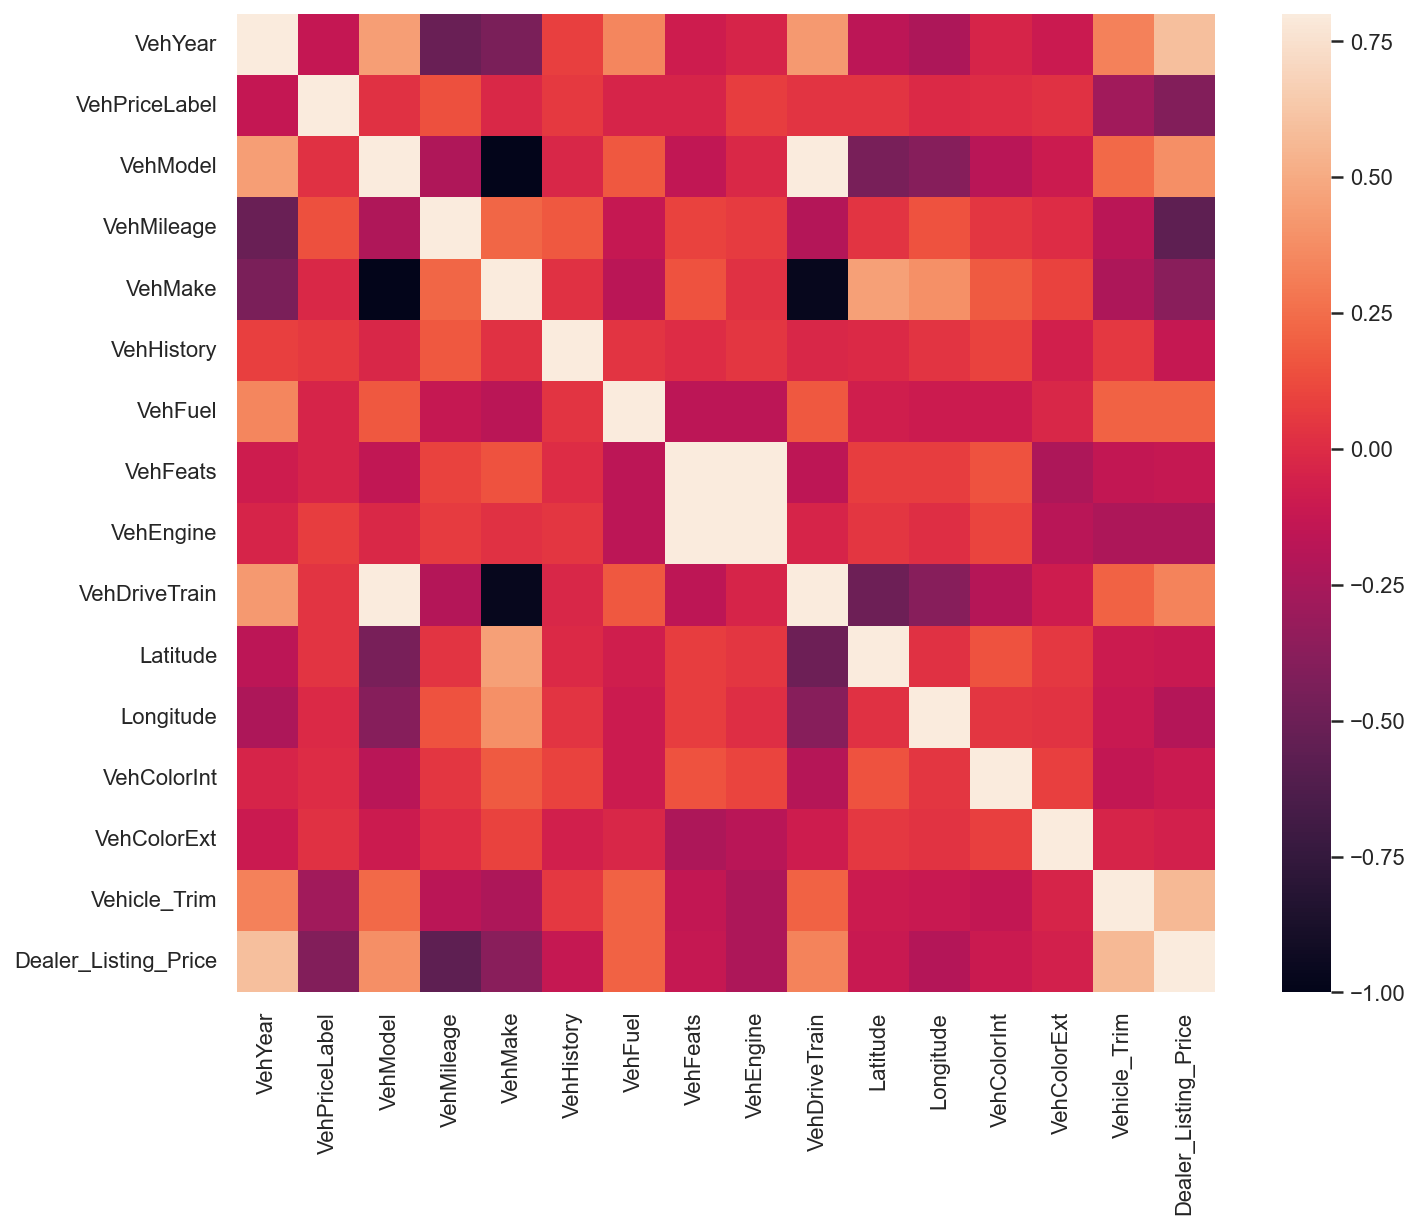

In [2321]:
car_train.head()
# Correlation Matrix Heatmap
corrmat = car_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


In [2322]:
car_train.head()

,VehYear,VehPriceLabel,VehModel,VehMileage,VehMake,VehHistory,VehFuel,VehFeats,VehEngine,VehDriveTrain,Latitude,Longitude,VehColorInt,VehColorExt,Vehicle_Trim,Dealer_Listing_Price
0,2015.0,0,0,39319.0,1,11216,2,3756,7419,1,42.4665,-83.0593,3593,1027,5,30990.0
2,2015.0,1,0,38957.0,1,9185,2,3569,2984,3,42.9993,-88.2196,3593,3703,6,23249.0
3,2018.0,1,0,20404.0,1,11216,2,5187,7419,0,38.8020,-90.8534,3593,3676,8,31977.0
4,2018.0,1,1,19788.0,0,11216,2,3637,4562,6,36.0992,-94.1716,131,2811,10,33495.0
5,2018.0,1,0,34649.0,1,11216,2,17406,15319,0,42.0821,-78.4260,3593,4282,8,27900.0


In [2323]:
skim(car_train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4966   │ │ int64       │ 11    │                                                          │
│ │ Number of columns │ 16     │ │ float64     │ 5     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0     ┃ p25    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ VehYear                   │   0 │      0 │    2000 │     1.2 │   2000 │   2000 │   2000 │   2000 │ ▆▂ ██▁  │  │
│ │ VehPriceLabel             │   0 │      0 │       1 │    0.51 │      0 │      1 │      1 │      2 │ ▁  █ ▂  │  │
│ │ VehModel                  │   0 │      0 │    0.31 │    0.46 │      0 │      0 │      1 │      1 │ █    ▄  │  │
│ │ VehMileage                │   0 │      0 │   27000 │   13000 │      5 │  17000 │  37000 │  83000 │  ▄█▇▃   │  │
│ │ VehMake                   │   0 │      0 │    0.69 │    0.46 │      0 │      0 │      1 │      1 │ ▄    █  │  │
│ │ VehHistory                │   0 │      0 │    9400 │    2000 │    300 │   9200 │  11000 │  12000 │   ▁ █▆  │  │
│ │ VehFuel                   │   0 │      0 │     1.9 │    0.29 │      0 │      2 │      2 │      3 │    ▁ █  │  │
│ │ VehFeats                  │   0 │      0 │   11000 │    6600 │      8 │   3800 │  17000 │  18000 │ ▂▅  ▃█  │  │
│ │ VehEngine                 │   0 │      0 │   11000 │    5500 │      4 │   4600 │  15000 │  16000 │ ▁▃▁ ▁█  │  │
│ │ VehDriveTrain             │   0 │      0 │     1.6 │     2.5 │      0 │      0 │      4 │      6 │ █   ▁▂  │  │
│ │ Latitude                  │   0 │      0 │      39 │     4.2 │     21 │     38 │     42 │     62 │   ▂██   │  │
│ │ Longitude                 │   0 │      0 │     -87 │     8.9 │   -160 │    -89 │    -81 │    -72 │     ▆█  │  │
│ │ VehColorInt               │   0 │      0 │    2800 │    1500 │      1 │    730 │   3600 │   5000 │ ▄   █▂  │  │
│ │ VehColorExt               │   0 │      0 │    2500 │    1400 │      1 │   1200 │   3300 │   5200 │ ▅▅▃█▅▂  │  │
│ │ Vehicle_Trim              │   0 │      0 │      10 │     5.4 │      0 │      8 │     14 │     25 │ ▁█▂▄ ▁  │  │
│ │ Dealer_Listing_Price      │   0 │      0 │   32000 │    7600 │  18000 │  27000 │  36000 │  90000 │   ██▁   │  │
│ └───────────────────────────┴─────┴────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴─────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

### Removing Outliers

Removing outliers for the training data:
1. price
2. trim


In [2324]:
def remove_outliers(df, columns, factor=1.5):
    df_clean = df.copy()
    for column in columns:
        q1 = np.percentile(df_clean[column], 25)
        q3 = np.percentile(df_clean[column], 75)
        iqr = q3 - q1
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]
    return df_clean

In [2325]:
len(numeric_cols)

21

### Splitting Training Data into 2 groups

1. Dealer Listing Price prediction --> regression method
2. Vehicle Trim prediction --> tree method

The test data doesn't contain either price or trim, therefore formatting the train data the same would come handy for prediction
Not going to remove outliers for Trim data because there are only 26 unique values

In [2326]:
price_train_cols = car_train.select_dtypes(include=['number']).columns.to_list()
price_train_cols.remove('Vehicle_Trim')

# Dealer Listing Price
price_train = remove_outliers(car_train,['Dealer_Listing_Price'])
price_train.drop(["Vehicle_Trim"], axis = 1, inplace = True)
#print(price_train.head())
price_train2 = remove_outliers(car_train,price_train_cols)
price_train2.drop(["Vehicle_Trim"], axis = 1, inplace = True)
#price_train2.head()

### Clean test data

### Modeling

Model going to be used: try 8 different methods and compare them

1. For decision tree and random forest --> zipcode should be in categorical value

In [2327]:
# Normalize Test data
scaled_car_test = pd.DataFrame(scaler.fit_transform(car_test), columns = car_test.columns)

In [2328]:
price_cols = price_train.columns.to_list()
# Normalize the data
scaler = StandardScaler()
scaled_price_train = pd.DataFrame(scaler.fit_transform(price_train), columns = price_cols)

# Training price
price_target = price_train['Dealer_Listing_Price'] # set target variable to new variable
price_train.drop(['Dealer_Listing_Price'], axis=1, inplace=True) # drop target variable column from train data
scaled_price_train.drop(['Dealer_Listing_Price'], axis=1, inplace=True) # drop target variable column from train data
train, test, target = price_train, car_test, price_target

In [2329]:
#scaled_price_train.head()
#scaled_trim_train.head()

Options:
1. Using PCA(n_components = x) --> get set number(x) of variables that are relevant to the model
2. Standard Scaler

In [2330]:
from sklearn.metrics import *

In [2331]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

def naive_roc_auc_score(y_true, y_pred):  
    num_same_sign = 0
    num_pairs = 0
    for a in range(len(y_true)):
        for b in range(len(y_true)):
            if y_true[a] > y_true[b]:
                num_pairs += 1
                if y_pred[a] > y_pred[b]:
                    num_same_sign += 1
                elif y_pred[a] == y_pred[b]:
                    num_same_sign += .5
    return num_same_sign / num_pairs

In [2332]:
def acc_model_train(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])
    print('ytest = ', ytest[:5])

    R2_train_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', R2_train_num)   
    R2_train.insert(num, R2_train_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    test_predict.insert(num,ytest)  
    print('value for test =', ytest)   

In [2333]:
R2_train = []
AUC_train = []
acc_train_d = []
acc_train_rmse = []
acc_test_rmse = []

test_predict = []


# Linear Regression

linreg = LinearRegression()
linreg.fit(scaled_price_train, price_target)
acc_model_train(0,linreg, scaled_price_train,car_test)

# Support Vector Machines

svr = SVR()
svr.fit(scaled_price_train, price_target)
acc_model_train(1,svr, scaled_price_train,car_test)

# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(scaled_price_train, price_target)
acc_model_train(2,linear_svr, scaled_price_train,car_test)

# Stochastic Gradient Descent

sgd = SGDRegressor()
sgd.fit(scaled_price_train, price_target)
acc_model_train(3,sgd, scaled_price_train,car_test)

# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(scaled_price_train, price_target)
acc_model_train(4,decision_tree, scaled_price_train,car_test)

# Random Forest

random_forest = RandomForestRegressor()
random_forest.fit(scaled_price_train, price_target)
acc_model_train(5,random_forest, scaled_price_train,car_test)

# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(scaled_price_train, price_target)
acc_model_train(6,ridge, scaled_price_train,car_test)

# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(scaled_price_train, price_target)
acc_model_train(7,bagging, scaled_price_train,car_test)

# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(scaled_price_train, price_target)
acc_model_train(8,etr, scaled_price_train,car_test)

# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(scaled_price_train, price_target)
acc_model_train(9,Ada_Boost, scaled_price_train,car_test)

# Gaussian NB

GNB = GaussianNB()
GNB.fit(scaled_price_train,price_target)
acc_model_train(10,GNB,scaled_price_train,car_test)

target =  [30990. 23249. 31977. 33495. 27900.]
ytrain =  [27101.4032084  22540.46913396 33471.52539695 37583.67966045
 30936.48875131]
ytest =  [-25203884.81877767 -87382741.41103134 -97684682.4562558
 -85251302.0007654  -48141406.07362805]
acc(r2_score) for train = 70.52
acc(relative error) for train = 7.83
acc(rmse) for train = 325896.03
value for test = [-2.52038848e+07 -8.73827414e+07 -9.76846825e+07 -8.52513020e+07
 -4.81414061e+07 -2.96671186e+07 -7.53545219e+07 -7.54423186e+07
 -4.05714471e+07 -6.52247115e+07 -4.85093401e+07 -5.04797429e+07
 -5.81048975e+07 -6.48755410e+07 -1.15981680e+07 -4.37067384e+07
 -1.52522087e+07 -6.21435882e+06 -8.10810244e+07 -3.25595369e+07
 -6.92425249e+07 -3.49132070e+07 -6.43746343e+07 -2.55659327e+07
 -2.58842140e+07 -6.65303177e+07 -1.77639434e+07 -4.65999141e+07
 -5.81448238e+07 -3.97795401e+07 -4.79606478e+07 -6.59668692e+07
 -2.80484439e+07 -2.14910442e+07 -5.01948719e+07 -3.27885509e+07
 -3.08671236e+07 -2.98940227e+07 -4.10538741e+07 -2.0640

In [2334]:
price_models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 'Stochastic Gradient Decent', 'Decision Tree Regressor', 
              'Random Forest', 'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 'AdaBoostRegressor', 'GaussianNB'],
    'r2_train': R2_train,
    'd_train': acc_train_d,
    'rmse_train': acc_train_rmse,
    'test_predict': test_predict
 })
price_models

,Model,r2_train,d_train,rmse_train,test_predict
0,Linear Regression,70.52,7.83,325896.03,"[-25203884.818777673, -87382741.41103134, -976..."
1,Support Vector Machines,5.27,15.17,584163.76,"[30860.070117492833, 30860.070117492833, 30860..."
2,Linear SVR,-1947.51,84.52,2715808.89,"[4851.000000346453, 4851.0000003592295, 4851.0..."
3,Stochastic Gradient Decent,70.41,7.85,326474.32,"[-24485121.70450056, -85763759.34422922, -9557..."
4,Decision Tree Regressor,100.00,0.00,101.52,"[33995.0, 33995.0, 33995.0, 33995.0, 33995.0, ..."
5,Random Forest,97.68,2.00,91401.81,"[29240.25, 29197.21, 29197.21, 29197.21, 29240..."
6,RidgeRegressor,70.52,7.83,325896.04,"[-25203261.26685359, -87380208.6521073, -97682..."
7,BaggingRegressor,96.54,2.27,111568.85,"[29030.4, 29030.4, 29030.4, 29030.4, 29030.4, ..."
8,ExtraTreesRegressor,100.00,0.00,203.05,"[34249.44, 33255.63, 33255.63, 33255.63, 34249..."
9,AdaBoostRegressor,70.53,8.31,325841.70,"[28912.36746987952, 28864.560747663552, 28864...."


In [2335]:
trim_train_cols = car_train.select_dtypes(include=['number']).columns.to_list()
trim_train_cols.remove('Dealer_Listing_Price')

# Trim
trim_train = car_train.copy(deep=True)
trim_train.drop(["Dealer_Listing_Price"], axis = 1, inplace = True)
#print(trim_train.head())
trim_train2 = remove_outliers(car_train,trim_train_cols)
trim_train2.drop(["Dealer_Listing_Price"], axis = 1, inplace = True)
#trim_train2.head()

In [2336]:
trim_train2.head()

,VehYear,VehPriceLabel,VehModel,VehMileage,VehMake,VehHistory,VehFuel,VehFeats,VehEngine,VehDriveTrain,Latitude,Longitude,VehColorInt,VehColorExt,Vehicle_Trim
3,2018.0,1,0,20404.0,1,11216,2,5187,7419,0,38.8020,-90.8534,3593,3676,8
5,2018.0,1,0,34649.0,1,11216,2,17406,15319,0,42.0821,-78.4260,3593,4282,8
9,2018.0,1,0,17692.0,1,11216,2,17406,15319,0,38.1890,-85.6540,3593,2944,8
12,2017.0,1,0,34437.0,1,9185,2,18181,15319,0,40.6148,-89.4604,3593,1201,8
19,2015.0,1,0,43231.0,1,9185,2,3834,2984,0,36.1897,-86.5023,3593,2944,8


In [2337]:
trim_train = trim_train2

In [2338]:
trim_cols = trim_train.columns.to_list()
# Normalize the data
scaler = StandardScaler()
scaled_trim_train = pd.DataFrame(scaler.fit_transform(trim_train), columns = trim_cols)

# Training price
trim_target = trim_train['Vehicle_Trim'] # set target variable to new variable
trim_train.drop(['Vehicle_Trim'], axis=1, inplace=True) # drop target variable column from train data
scaled_trim_train.drop(['Vehicle_Trim'], axis=1, inplace=True) # drop target variable column from train data
train, test, target = trim_train, car_test, trim_target

In [ ]:
trim_train["VehPriceLabel"].value_counts()

In [2339]:
def trim_acc_model_train(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])
    print('ytest = ', ytest[:5])

    R2_train_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', R2_train_num)   
    R2_train.insert(num, R2_train_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    test_predict.insert(num,np.round(ytest,decimals=0))
    print('value for test =', ytest)  

In [2340]:
scaled_trim_train.head()

,VehYear,VehPriceLabel,VehModel,VehMileage,VehMake,VehHistory,VehFuel,VehFeats,VehEngine,VehDriveTrain,Latitude,Longitude,VehColorInt,VehColorExt
0,1.302276,0.0,0.0,-0.837399,0.0,0.981767,0.0,-1.133659,-0.782781,-0.096927,-0.711049,-1.263473,0.0,0.685149
1,1.302276,0.0,0.0,0.333700,0.0,0.981767,0.0,0.612665,0.671588,-0.096927,0.547806,1.187480,0.0,1.061721
2,1.302276,0.0,0.0,-1.060356,0.0,0.981767,0.0,0.612665,0.671588,-0.096927,-0.946309,-0.238039,0.0,0.230281
3,0.500939,0.0,0.0,0.316271,0.0,-0.818500,0.0,0.723427,0.671588,-0.096927,-0.015322,-0.988743,0.0,-0.852827
4,-1.101734,0.0,0.0,1.039236,0.0,-0.818500,0.0,-1.327028,-1.599253,-0.096927,-1.713612,-0.405342,0.0,0.230281


In [2341]:
print('Trim')

R2_train = []
AUC_train = []
acc_train_d = []
acc_train_rmse = []
acc_test_rmse = []

test_predict = []


# Linear Regression

linreg = LinearRegression()
linreg.fit(scaled_trim_train, trim_target)
trim_acc_model_train(0,linreg, scaled_trim_train,car_test)

# Support Vector Machines

svr = SVR()
svr.fit(scaled_trim_train, trim_target)
trim_acc_model_train(1,svr, scaled_trim_train,car_test)

# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(scaled_trim_train, trim_target)
trim_acc_model_train(2,linear_svr, scaled_trim_train,car_test)

# Stochastic Gradient Descent

sgd = SGDRegressor()
sgd.fit(scaled_trim_train, trim_target)
trim_acc_model_train(3,sgd, scaled_trim_train,car_test)

# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(scaled_trim_train, trim_target)
trim_acc_model_train(4,decision_tree, scaled_trim_train,car_test)

# Random Forest

random_forest = RandomForestRegressor()
random_forest.fit(scaled_trim_train, trim_target)
trim_acc_model_train(5,random_forest, scaled_trim_train,car_test)

# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(scaled_trim_train, trim_target)
trim_acc_model_train(6,ridge, scaled_trim_train,car_test)

# Bagging Regressor

bagging = BaggingRegressor()
bagging.fit(scaled_trim_train, trim_target)
trim_acc_model_train(7,bagging, scaled_trim_train,car_test)

# Extra Trees Regressor

etr = ExtraTreesRegressor()
etr.fit(scaled_trim_train, trim_target)
trim_acc_model_train(8,etr, scaled_trim_train,car_test)

# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(scaled_trim_train, trim_target)
trim_acc_model_train(9,Ada_Boost, scaled_trim_train,car_test)

# Gaussian NB

GNB = GaussianNB()
GNB.fit(scaled_trim_train,trim_target)
trim_acc_model_train(10,GNB,scaled_trim_train,car_test)

Trim
target =  [8 8 8 8 8]
ytrain =  [8. 8. 8. 8. 8.]
ytest =  [8. 8. 8. 8. 8.]
acc(r2_score) for train = 100.0
acc(relative error) for train = 0.0
acc(rmse) for train = 0.0
value for test = [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.
 8. 8.

In [2342]:
trim_models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 'Stochastic Gradient Decent', 'Decision Tree Regressor', 
              'Random Forest', 'RidgeRegressor', 'BaggingRegressor', 'ExtraTreesRegressor', 'AdaBoostRegressor', 'GaussianNB'],
    'r2_train': R2_train,
    'd_train': acc_train_d,
    'rmse_train': acc_train_rmse,
    'test_predict': test_predict
 })
trim_models

,Model,r2_train,d_train,rmse_train,test_predict
0,Linear Regression,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
1,Support Vector Machines,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
2,Linear SVR,0.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
3,Stochastic Gradient Decent,0.0,0.03,0.53,"[7.0, -39.0, 27.0, 58.0, 12.0, 26.0, 56.0, 56...."
4,Decision Tree Regressor,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
5,Random Forest,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
6,RidgeRegressor,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
7,BaggingRegressor,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
8,ExtraTreesRegressor,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
9,AdaBoostRegressor,100.0,0.00,0.00,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."


In [2343]:
trim_models["test_predict"][7]

array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8.